<a href="https://colab.research.google.com/github/mma-fsa/urban_rural_heart_deaths/blob/main/1_create_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study Data Creation

## Summary

### CDC Death Data

The study uses cardiac (I00-I99) deaths from [CDC Wonder](https://wonder.cdc.gov/mcd-icd10-provisional.html). Deaths are aggregated by county, 10 year ages, and calendar year.

### Census Data - American Community Survey (ACS)

Three variables are used from the 2022 ACS Survey.

1. The percent of county residents within various increments of the [federal poverty levels](https://aspe.hhs.gov/sites/default/files/documents/7240229f28375f54435c5b83a3764cd1/detailed-guidelines-2024.pdf).

2. The percent of county residents with health insurance coverage.

3. The percent of county residents with *public* health insurance coverage (Medicaid / Medicare).

### RUCA codes

The USDA publishes census-tract level classifications of urban vs. rural areas called [Rural-Urban Commuting Area codes](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes.aspx).  These numbers range 1-10, with 1 being urban and 10 being very rural.  Precise definitions are available at the link.

Each county is assigned a population-weighted RUCA code based on its constitutient census tracts and the population of each tract.

### CDC PLACES Data

The [CDC Places](https://www.cdc.gov/places/index.html) data includes census-tract level information about the percent of county residents with obesity, heart disease, and other important health factors.

## Query CDC Data

The **death data** is queried from the [CDC Provisional Mortality Statistics Database](https://wonder.cdc.gov/mcd-icd10-provisional.html).  Since the web API disallows county-level queries, this will need to be performed through the web interface, using the export functionality.

For convenience, a pre-built file is downloaded and provided below.  Otherwise, follow the steps in the Appendix to create the file yourself.

In [1]:
!wget https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/Provisional%20Mortality%20Statistics%2C%202018%20through%20Last%20Week.txt

--2024-12-01 16:12:19--  https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/Provisional%20Mortality%20Statistics%2C%202018%20through%20Last%20Week.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304780 (298K) [text/plain]
Saving to: ‘Provisional Mortality Statistics, 2018 through Last Week.txt’

Provisional Mortali 100%[===================>] 297.64K  --.-KB/s    in 0.04s   

2024-12-01 16:12:20 (6.52 MB/s) - ‘Provisional Mortality Statistics, 2018 through Last Week.txt’ saved [304780/304780]



In [2]:
from logging import error
import pandas as pd

cardiac_deaths = pd.read_csv("Provisional Mortality Statistics, 2018 through Last Week.txt", sep="\t", on_bad_lines='warn')
cardiac_deaths = cardiac_deaths[~pd.isna(cardiac_deaths["Deaths"])]
# zero-pad the FIPS (county) code so that it is 5 digits
cardiac_deaths['Residence County Code'] = cardiac_deaths['Residence County Code']\
  .astype(int)\
  .astype(str)\
  .str.zfill(5)

cardiac_deaths = cardiac_deaths.drop("Notes", axis=1)
cardiac_deaths.columns = [
    "COUNTY_DESC",
    "FULL_FIPS",
    "AGE_GROUP",
    "AGE_GROUP_CODE",
    "DEATHS"]

cardiac_deaths["STATE_FIPS"] = cardiac_deaths["FULL_FIPS"].str[:2]
cardiac_deaths["COUNTY_FIPS"] = cardiac_deaths["FULL_FIPS"].str[2:]

cardiac_deaths

,COUNTY_DESC,FULL_FIPS,AGE_GROUP,AGE_GROUP_CODE,DEATHS,STATE_FIPS,COUNTY_FIPS
0,"Autauga County, AL",01001,55-64 years,55-64,15.0,01,001
1,"Autauga County, AL",01001,65-74 years,65-74,39.0,01,001
2,"Baldwin County, AL",01003,45-54 years,45-54,25.0,01,003
3,"Baldwin County, AL",01003,55-64 years,55-64,73.0,01,003
4,"Baldwin County, AL",01003,65-74 years,65-74,127.0,01,003
...,...,...,...,...,...,...,...
5322,"Sheridan County, WY",56033,55-64 years,55-64,11.0,56,033
5323,"Sheridan County, WY",56033,65-74 years,65-74,21.0,56,033
5324,"Sweetwater County, WY",56037,55-64 years,55-64,10.0,56,037
5325,"Sweetwater County, WY",56037,65-74 years,65-74,21.0,56,037


## Query Census Data

We need the following information from the U.S. census.  We'll use the 2022 American Community Survey (ACS) to best align with the 2022 CDC data.  The census bureau offers a handy API that can be used to pull this information somewhat easily, but you'll need to sign-up for an API key.  

1. County-level population by age.  In order to compute a mortality rate ($q_x$), we need the population, i.e. $q_x = \frac{deaths}{lives}$.

2. County-level economic information, by age.  This data provides age-banded populations of county residents in households at various levels relative to the federal poverty guidelines.

3. County-level health insurance status, the percent of the population with and without health insurance.

4. Public vs. private health insurance status.  For ages under 65, the percent of the population with public health insurance is mostly Medicaid recipients, which will be strongly correlated with the percent of the population with household incomes near the poverty line.  For ages over 65, this variable will have limited influence, since the majority of the population is on Medicare.

5. County-level [Rural-Urban Commuting Area](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/) codes (RUCA), population weighted. These codes are at the census tract level, so we'll assign the 1-10 codes to each tract, and compute the population-weighted average within each county.  A pre-cleaned CSV is downloaded that is sourced from the Excel file at the above link.

**Installing the tidycensus package takes a long time on colab.**  

In [3]:
# @title Query data from U.S. census (enter API key in textbox)
api_key = "822265783b1b5d7637807043dfe0873ef23ca90e" # @param {"type":"string"}

import rpy2
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri

# hack to fix rpy2 conversions
pd.DataFrame.iteritems = pd.DataFrame.items

%load_ext rpy2.ipython
%Rpush api_key

### Exposure calculation

In [4]:
%%R
# the tidy census package makes querying US census data via the API relatively easy,
# installing the package will take ~10 minutes on colab
suppressMessages({
  if (!require("tidycensus")) {
    install.packages("tidycensus")
  }
  if (!require("tidyverse")) {
    install.packages("tidyverse")
  }
  library(tidycensus)
  library(tidyverse)
})















































	‘/tmp/RtmpW4IRXk/downloaded_packages’



In [6]:
%%R

Sys.setenv("CENSUS_API_KEY" = api_key)

# get a list of all the ACS variables, we'll filter for the ones we need
all_acs_vars <- tidycensus::load_variables(2022, dataset = "acs5")

# population (exposure) variables
exposure_vars <- all_acs_vars %>%
  filter(stringr::str_detect(name, regex("^B01001.*$")))

# economic variables, % of population at various income levels relative
# to the poverty line
economic_vars <- all_acs_vars %>%
  filter(str_detect(name, regex("^B17024.*$")))

# health insurance status (insured vs. uninsured)
health_ins_vars <- all_acs_vars %>%
  filter(str_detect(name, regex("^B27001.*$")))

# public health insurance status (Medicaid+Medicare vs. Uninsured+Commercial)
public_health_ins_vars <- all_acs_vars %>%
  filter(str_detect(name, regex("^B27003.*$")))

print("done")


[1] "done"


In [7]:
%%R -i cardiac_deaths

# fetch the exposure variables, since this is being done at the
# census tract level, it takes ~17 minutes
if (!file.exists("acs_exposures_2022.rds")) {

  acs_exposures <- tidycensus::get_acs(geography = "county",
                      year=2022,
                      variables=exposure_vars$name,
                      state = unique(cardiac_deaths$STATE_FIPS),
                      cache_table = T)

  acs_exposures %>%
    write_rds("acs_exposures_2022.rds", compress="gz")

} else {
  acs_exposures <- read_rds("acs_exposures_2022.rds")
}

# append age group and sex to each of the variables
VARNAME_REGEXP <- ".*?!!.*?!!(.*?):!!(.*?)$"

# age groups that we want to retain for the study
AGE_GROUPS <- c("35-44", "45-54", "55-64", "65-74")

# extract the age and sex from the census variable description
exposure_var_attrs <- exposure_vars %>%
  filter(str_detect(label, "(.*?!!){3}")) %>%
  mutate(
    GENDER = str_trim(str_extract(
      label, VARNAME_REGEXP, group=1)),
    AGE_GROUP_CODE = str_extract(
      label, VARNAME_REGEXP, group=2),
    AGE_GROUP_CODE = str_replace_all(AGE_GROUP_CODE, " to ", "-"),
    AGE_GROUP_CODE = str_trim(str_replace_all(AGE_GROUP_CODE, "years", ""))
  ) %>%
  select(
    variable=name,
    GENDER,
    AGE_GROUP_CODE
  )

# since we didn't include GENDER in the death data, just group by age and county fips
final_exposures <- acs_exposures %>%
  inner_join(exposure_var_attrs, by=c("variable")) %>%
  mutate(FULL_FIPS = substr(GEOID, 1, 5)) %>%
  rename(EXPOSURES = estimate) %>%
  filter(AGE_GROUP_CODE %in% AGE_GROUPS) %>%
  group_by(FULL_FIPS, AGE_GROUP_CODE) %>%
  summarise(
    EXPOSURES = sum(EXPOSURES),
    .groups="drop"
  ) %>%
  ungroup()

final_exposures %>% head(100) %>% print()

# A tibble: 100 × 3
   FULL_FIPS AGE_GROUP_CODE EXPOSURES
   <chr>     <chr>              <dbl>
 1 01001     35-44              13646
 2 01001     45-54              13948
 3 01001     55-64              13922
 4 01001     65-74               9641
 5 01003     35-44              52574
 6 01003     45-54              56304
 7 01003     55-64              63913
 8 01003     65-74              57110
 9 01005     35-44               4634
10 01005     45-54               4579
# ℹ 90 more rows
# ℹ Use `print(n = ...)` to see more rows


### Plot the death rate (cardiac) by age

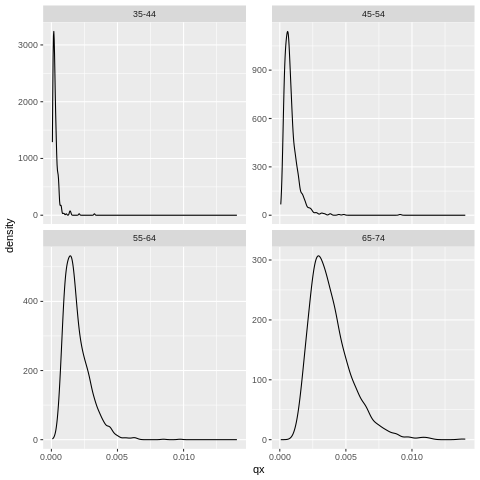

In [8]:
%%R

plot_data <- cardiac_deaths %>%
  inner_join(final_exposures, by=c("FULL_FIPS"="FULL_FIPS", "AGE_GROUP_CODE"="AGE_GROUP_CODE")) %>%
  mutate(qx = DEATHS / EXPOSURES)

ggplot(plot_data, aes(x=qx)) +
  facet_wrap(~ AGE_GROUP_CODE, scales="free_y") +
  geom_density()

### Query the predictor variables from the census

In [12]:
%%R

if (!file.exists("acs_predictors_2022.rds")) {

  acs_predictors <- tidycensus::get_acs(geography = "county",
                      year=2022,
                      variables=c(
                        economic_vars$name,
                        health_ins_vars$name,
                        public_health_ins_vars$name
                      ),
                      state = unique(cardiac_deaths$STATE_FIPS),
                      cache_table = T)

  acs_predictors %>%
    write_rds("acs_predictors_2022.rds", compress="gz")
} else {
  acs_predictors <- read_rds("acs_predictors_2022.rds")
}


### Get the economic variables

In [26]:
%%R

# extract age & poverty groups from the variable descriptions
econ_var_descriptions <- economic_vars %>%
  mutate(
    cohort_total = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+$"),
    cohort_subtotal = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+!![^!]+$")
  ) %>%
  filter(cohort_total | cohort_subtotal) %>%
  mutate(
    age_group = str_extract(label, "^[^!]+!![^!]+!!([^!]+):(!![^!]+)?$", group=1),
    poverty_group = str_extract(label, "^[^!]+!![^!]+!![^!]+:!!([^!]+)$", group=1),
    age_group = str_replace_all(age_group, " to ", "-"),
    age_group = str_replace_all(age_group, "years", ""),
    var_group = "econ"
  ) %>%
  select(
    name,
    age_group,
    poverty_group,
    cohort_total,
    cohort_subtotal
  )

# join the data pulled from ACS to the descriptions (age & poverty groups),
# the bins used by the census bureau are quite fine, so roll them up into 4 groups:
# poverty income (<=150% of FPL), low income (150%-200%), middle income (200%-400%),
# upper income (400%+)
econ_var_data <- acs_predictors %>%
  inner_join(econ_var_descriptions, by=c("variable"="name")) %>%
  mutate(COUNTY_FIPS = stringr::str_sub(GEOID, 1, 5)) %>%
  filter(cohort_subtotal == T) %>%
  mutate(
    age_group = stringr::str_trim(age_group),
    poverty_group2 = case_when(
      poverty_group %in% c("Under .50" , ".50 to .74", ".75 to .99", "1.00 to 1.24", "1.25 to 1.49") ~ "poverty_income",
      poverty_group %in% c("1.75 to 1.84",  "1.85 to 1.99") ~ "low_income",
      poverty_group %in% c( "2.00 to 2.99",  "3.00 to 3.99") ~ "middle_income",
      poverty_group %in% c( "4.00 to 4.99",  "5.00 and over") ~ "upper_income"
    )
  ) %>%
  select(COUNTY_FIPS, age_group, poverty_group=poverty_group2, COHORT_POP_AT_AGE=estimate) %>%
  group_by(COUNTY_FIPS, age_group, poverty_group) %>%
  summarise(
    COHORT_POP_AT_AGE = sum(COHORT_POP_AT_AGE),
    .groups="drop"
  ) %>%
  ungroup() %>%
  group_by(COUNTY_FIPS, age_group) %>%
  mutate(
    TOTAL_POP_AT_AGE = sum(COHORT_POP_AT_AGE)
  ) %>%
  ungroup() %>%
  filter(!is.na(poverty_group))

# the final data frame is the proportion of county population within each of
# the 4 income buckets defined above, by age group
econ_var_data <- econ_var_data %>%
  filter(TOTAL_POP_AT_AGE > 0) %>%
  mutate(PCT = COHORT_POP_AT_AGE / TOTAL_POP_AT_AGE) %>%
  select(-COHORT_POP_AT_AGE, -TOTAL_POP_AT_AGE) %>%
  pivot_wider(id_cols = c(COUNTY_FIPS, age_group), names_from = poverty_group, values_from = PCT, values_fill = 0) %>%
  filter(age_group %in% AGE_GROUPS)

econ_var_data

# A tibble: 12,574 × 6
   COUNTY_FIPS age_group low_income middle_income poverty_income upper_income
   <chr>       <chr>          <dbl>         <dbl>          <dbl>        <dbl>
 1 01001       35-44         0.0342         0.368          0.178        0.401
 2 01001       45-54         0.0149         0.283          0.183        0.481
 3 01001       55-64         0.0501         0.235          0.215        0.470
 4 01001       65-74         0.0345         0.367          0.201        0.366
 5 01003       35-44         0.0467         0.357          0.134        0.427
 6 01003       45-54         0.0444         0.279          0.136        0.512
 7 01003       55-64         0.0433         0.248          0.179        0.500
 8 01003       65-74         0.0452         0.324          0.134        0.462
 9 01005       35-44         0.0550         0.298          0.334        0.281
10 01005       45-54         0.0534         0.283          0.245        0.369
# ℹ 12,564 more rows
# ℹ Use `print(n = .

### Get health insurance status

In [29]:
%%R

# extract age group and health insurance status from census variable descriptions
health_ins_var_desc <- health_ins_vars %>%
  mutate(
    cohort_total = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+!![^!]+$"),
    cohort_subtotal = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+!![^!]+!![^!]+$")
  ) %>%
  filter(cohort_total | cohort_subtotal) %>%
  mutate(
    sex = str_extract(label, "^[^!]+!![^!]+!!([^!]+):(!![^!]+)+.*$$", group=1),
    age_group = str_extract(label, "^[^!]+!![^!]+!![^!]+:!!([^!:]+)[: ]*.*$", group=1),
    age_group = str_replace_all(age_group, " to ", "-"),
    age_group = str_replace_all(age_group, "years", ""),
    var_group = "health_ins",
    var_subgroup = str_extract(label, "^[^!]+!![^!]+!![^!]+:!![^!]+!!([^!]+)$", group=1)
  )

# join the data to the variable descriptions pull from the ACS
hi_var_data <- acs_predictors %>%
  inner_join(health_ins_var_desc, by=c("variable"="name"))
hi_cohort_subtotals <- hi_var_data %>%
  mutate(COUNTY_FIPS = stringr::str_sub(GEOID, 1, 5)) %>%
  filter(cohort_subtotal == T) %>%
  mutate(
    age_group = stringr::str_trim(age_group),
    hi_group2 = case_when(
      var_subgroup == "With health insurance coverage" ~ "has_health_ins",
      var_subgroup == "No health insurance coverage" ~ "no_health_ins")) %>%
  select(COUNTY_FIPS, age_group, hi_group=hi_group2, COHORT_POP_AT_AGE=estimate) %>%
  group_by(COUNTY_FIPS, age_group, hi_group) %>%
  summarise(
    COHORT_POP_AT_AGE = sum(COHORT_POP_AT_AGE),
    .groups="drop"
  ) %>%
  ungroup() %>%
  group_by(COUNTY_FIPS, age_group) %>%
  mutate(
    TOTAL_POP_AT_AGE = sum(COHORT_POP_AT_AGE)
  ) %>%
  ungroup() %>%
  filter(!is.na(hi_group))

hi_vars_final <- hi_cohort_subtotals %>%
    filter(TOTAL_POP_AT_AGE > 0) %>%
    mutate(PCT = COHORT_POP_AT_AGE / TOTAL_POP_AT_AGE) %>%
    select(-COHORT_POP_AT_AGE, -TOTAL_POP_AT_AGE) %>%
    pivot_wider(id_cols = c(COUNTY_FIPS, age_group), names_from = hi_group, values_from = PCT, values_fill = 0) %>%
    filter(age_group %in% AGE_GROUPS)

head(hi_vars_final)


# A tibble: 6 × 4
  COUNTY_FIPS age_group has_health_ins no_health_ins
  <chr>       <chr>              <dbl>         <dbl>
1 01001       35-44              0.871       0.129  
2 01001       45-54              0.945       0.0545 
3 01001       55-64              0.900       0.0999 
4 01001       65-74              0.996       0.00379
5 01003       35-44              0.850       0.150  
6 01003       45-54              0.882       0.118  


### Compute the percent of each age group that is male

Males have elevated cardiac death risk at younger ages, include the percent of the population that is male so that the analysis can account for significant gender differences in population (if any exist).

In [31]:
%%R

sex_var_totals <- hi_var_data %>%
  filter(cohort_total == T) %>%
  mutate(
    age_group = stringr::str_trim(age_group),
    COUNTY_FIPS = stringr::str_sub(GEOID, 1, 5)) %>%
  select(COUNTY_FIPS, age_group, sex, TOTAL_POP_AT_AGE = estimate) %>%
  group_by(COUNTY_FIPS, age_group, sex) %>%
  summarise(
    TOTAL_POP_AT_AGE = sum(TOTAL_POP_AT_AGE),
    .groups="drop"
  ) %>%
  ungroup() %>%
  group_by(COUNTY_FIPS, age_group) %>%
  mutate(
    PCT_MALE = TOTAL_POP_AT_AGE / sum(TOTAL_POP_AT_AGE)
  ) %>%
  ungroup() %>%
  filter(sex == "Male", age_group %in% AGE_GROUPS) %>%
  select(COUNTY_FIPS, age_group, PCT_MALE)

sex_var_totals


# A tibble: 12,576 × 3
   COUNTY_FIPS age_group PCT_MALE
   <chr>       <chr>        <dbl>
 1 01001       35-44        0.449
 2 01001       45-54        0.496
 3 01001       55-64        0.495
 4 01001       65-74        0.461
 5 01003       35-44        0.485
 6 01003       45-54        0.479
 7 01003       55-64        0.472
 8 01003       65-74        0.471
 9 01005       35-44        0.421
10 01005       45-54        0.426
# ℹ 12,566 more rows
# ℹ Use `print(n = ...)` to see more rows


### Public vs. Private Health Insurance

* For the population under 65, most of the public health insurance is likely Medicaid.  

* This will have limited (if any) effect for the population over 65, since the majority will be Medicare recipients.

In [33]:
%%R

public_health_ins_var_desc <- public_health_ins_vars %>%
  mutate(
    cohort_total = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+!![^!]+$"),
    cohort_subtotal = stringr::str_detect(label, "^[^!]+!![^!]+!![^!]+!![^!]+!![^!]+$")
  ) %>%
  filter(cohort_total | cohort_subtotal) %>%
  mutate(
    sex = str_extract(label, "^[^!]+!![^!]+!!([^!]+):(!![^!]+)+.*$$", group=1),
    age_group = str_extract(label, "^[^!]+!![^!]+!![^!]+:!!([^!:]+)[: ]*.*$", group=1),
    age_group = str_replace_all(age_group, " to ", "-"),
    age_group = str_replace_all(age_group, "years", ""),
    var_group = "health_ins",
    var_subgroup = str_extract(label, "^[^!]+!![^!]+!![^!]+:!![^!]+!!([^!]+)$", group=1)
  )

pub_hi_var_data <- acs_predictors %>%
  inner_join(public_health_ins_var_desc, by=c("variable"="name"))

pub_hi_var_data <- pub_hi_var_data %>%
  mutate(COUNTY_FIPS = stringr::str_sub(GEOID, 1, 5)) %>%
  filter(cohort_subtotal == T) %>%
  mutate(
    age_group = stringr::str_trim(age_group),
    hi_group2 = case_when(
      var_subgroup == "With public coverage" ~ "has_pub_hi",
      var_subgroup == "No public coverage" ~ "no_pub_hi")) %>%
  select(COUNTY_FIPS, age_group, hi_group=hi_group2, COHORT_POP_AT_AGE=estimate) %>%
  group_by(COUNTY_FIPS, age_group, hi_group) %>%
  summarise(
    COHORT_POP_AT_AGE = sum(COHORT_POP_AT_AGE),
    .groups="drop"
  ) %>%
  ungroup() %>%
  group_by(COUNTY_FIPS, age_group) %>%
  mutate(
    TOTAL_POP_AT_AGE = sum(COHORT_POP_AT_AGE)
  ) %>%
  filter(!is.na(hi_group)) %>%
  ungroup()

pub_hi_vars_final <- pub_hi_var_data %>%
    filter(TOTAL_POP_AT_AGE > 0) %>%
    mutate(PCT = COHORT_POP_AT_AGE / TOTAL_POP_AT_AGE) %>%
    select(-COHORT_POP_AT_AGE, -TOTAL_POP_AT_AGE) %>%
    pivot_wider(id_cols = c(COUNTY_FIPS, age_group), names_from = hi_group, values_from = PCT, values_fill = 0) %>%
    filter(age_group %in% AGE_GROUPS)

print(head(pub_hi_vars_final))

# A tibble: 6 × 4
  COUNTY_FIPS age_group has_pub_hi no_pub_hi
  <chr>       <chr>          <dbl>     <dbl>
1 01001       35-44          0.139    0.861 
2 01001       45-54          0.170    0.830 
3 01001       55-64          0.282    0.718 
4 01001       65-74          0.973    0.0267
5 01003       35-44          0.111    0.889 
6 01003       45-54          0.124    0.876 


## Compute the population weighted RUCA for each county

RUCA codes range 1-10, with 1 being an urban area, and 10 being rural.  The full description can be found on the [USDA website](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/documentation/).



In [9]:
!wget https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/ruca_codes_2010.csv.gz && gunzip ruca_codes_2010.csv.gz


--2024-12-01 16:46:11--  https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/ruca_codes_2010.csv.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/ruca_codes_2010.csv.gz [following]
--2024-12-01 16:46:11--  https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/ruca_codes_2010.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1499703 (1.4M) [application/octet-stream]
Saving to: ‘ruca_codes_2010.csv.gz’

ruca_codes_2010.csv 100%[===================>]   1.43M  --.-KB/s    in 0.07s 

In [10]:
%%R
ruca_codes <- read_csv("ruca_codes_2010.csv")
pop_wt_ruca <- ruca_codes %>%
  rename(FULL_FIPS = `State-County FIPS Code`) %>%
  group_by(FULL_FIPS) %>%
  mutate(
    pop_wt_ruca = `Tract Population, 2010` * `Secondary RUCA Code, 2010 (see errata)`
  ) %>%
  group_by(
    FULL_FIPS
  ) %>%
  summarise(
    pop_wt_ruca = sum(pop_wt_ruca) / sum(`Tract Population, 2010`),
    .groups = "drop"
  ) %>%
  ungroup()

print(pop_wt_ruca %>% head(10))

Rows: 74002 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): State-County FIPS Code, Select State, Select County, State-County-T...
dbl (5): Primary RUCA Code 2010, Secondary RUCA Code, 2010 (see errata), Tra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 10 × 2
   FULL_FIPS pop_wt_ruca
   <chr>           <dbl>
 1 01001            1.47
 2 01003            2.99
 3 01005            7.93
 4 01007            2   
 5 01009            4.72
 6 01011            2   
 7 01013            7.28
 8 01015            1.30
 9 01017            3.92
10 01019            2.47


## CDC Places Data

The CDC publishes county-level information about several important health variables, including the percent of the population that smokes, has diabetes, is obese, and is on blood pressure medication.

A full list of the variables is available on the [CDC places data website](https://www.cdc.gov/places/tools/data-portal.html).  Since the deaths are from 2022, the corresponding [2022 dataset](https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/duw2-7jbt/about_data) is used.

For convenience, this file is automatically downloaded in the next step

In [34]:
!wget https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv.gz && gunzip PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv.gz

--2024-12-01 18:56:38--  https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv.gz [following]
--2024-12-01 18:56:38--  https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [39]:
%%R

places_data <- read_csv("PLACES__Local_Data_for_Better_Health__County_Data_2022_release_20241201.csv") %>%
  mutate(COUNTY_FIPS = as.character(LocationID),
         COUNTY_FIPS = stringr::str_pad(COUNTY_FIPS, width = 2, pad="0"))

head(places_data)

Rows: 188456 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): StateAbbr, StateDesc, LocationName, DataSource, Category, Measure,...
dbl  (5): Year, Data_Value, Low_Confidence_Limit, High_Confidence_Limit, Tot...
lgl  (2): Data_Value_Footnote_Symbol, Data_Value_Footnote

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 × 22
   Year StateAbbr StateDesc     LocationName   DataSource Category       Measure
  <dbl> <chr>     <chr>         <chr>          <chr>      <chr>          <chr>  
1  2020 US        United States <NA>           BRFSS      Prevention     Curren…
2  2020 AL        Alabama       Talladega      BRFSS      Health Outcom… Diagno…
3  2020 AL        Alabama       Tallapoosa     BRFSS      Health Outcom… Diagno…
4  2020 AL        Alabama       Wilcox         BRFSS      Prevention     Visits…
5

In [70]:
%%R

cdc_places_vars <- places_data %>%
  filter(Year == 2020, DataValueTypeID=="AgeAdjPrv") %>%
  select(COUNTY_FIPS, Geolocation, MeasureId, Data_Value) %>%
  pivot_wider(id_cols=c(COUNTY_FIPS, Geolocation), names_from = MeasureId, values_from = Data_Value)

head(cdc_places_vars)

# A tibble: 6 × 28
  COUNTY_FIPS Geolocation           CHECKUP STROKE  COPD DENTAL CASTHMA CSMOKING
  <chr>       <chr>                   <dbl>  <dbl> <dbl>  <dbl>   <dbl>    <dbl>
1 01131       POINT (-87.3049349 3…    79.4    5.3  10     46.4    11.9     25.2
2 02100       POINT (-135.5757906 …    64      2.9   5.7   61       9.5     18.1
3 02198       POINT (-133.1623885 …    62.9    3.9   7.4   54.6    10.7     24.5
4 04013       POINT (-112.4989296 …    69.9    2.6   5.6   61.7    10.1     14.6
5 04025       POINT (-112.5772247 …    65.8    2.7   6.6   58.3    11.1     17.4
6 05103       POINT (-92.8784131 3…    77.3    4.1   8.9   51.5    11.3     24.4
# ℹ 20 more variables: COLON_SCREEN <dbl>, CANCER <dbl>, DIABETES <dbl>,
#   CERVICAL <dbl>, DEPRESSION <dbl>, CHD <dbl>, ARTHRITIS <dbl>, BINGE <dbl>,
#   OBESITY <dbl>, TEETHLOST <dbl>, GHLTH <dbl>, MAMMOUSE <dbl>, ACCESS2 <dbl>,
#   SLEEP <dbl>, MHLTH <dbl>, KIDNEY <dbl>, LPA <dbl>, PHLTH <dbl>,
#   COREM <dbl>, COREW <dbl>


## Create final dataframe

In [71]:
%%R

colnames(cdc_places_vars)

 [1] "COUNTY_FIPS"  "Geolocation"  "CHECKUP"      "STROKE"       "COPD"        
 [6] "DENTAL"       "CASTHMA"      "CSMOKING"     "COLON_SCREEN" "CANCER"      
[11] "DIABETES"     "CERVICAL"     "DEPRESSION"   "CHD"          "ARTHRITIS"   
[16] "BINGE"        "OBESITY"      "TEETHLOST"    "GHLTH"        "MAMMOUSE"    
[21] "ACCESS2"      "SLEEP"        "MHLTH"        "KIDNEY"       "LPA"         
[26] "PHLTH"        "COREM"        "COREW"       


In [72]:
%%R

final_data <- cardiac_deaths %>%
  inner_join(final_exposures, by=c("FULL_FIPS"="FULL_FIPS", "AGE_GROUP_CODE"="AGE_GROUP_CODE")) %>%
  inner_join(econ_var_data, by=c("FULL_FIPS"="COUNTY_FIPS", "AGE_GROUP_CODE"="age_group")) %>%
  inner_join(hi_vars_final, by=c("FULL_FIPS"="COUNTY_FIPS", "AGE_GROUP_CODE"="age_group")) %>%
  inner_join(pub_hi_vars_final, by=c("FULL_FIPS"="COUNTY_FIPS", "AGE_GROUP_CODE"="age_group")) %>%
  inner_join(pop_wt_ruca, by=c("FULL_FIPS"="FULL_FIPS")) %>%
  inner_join(sex_var_totals, by=c("FULL_FIPS"="COUNTY_FIPS", "AGE_GROUP_CODE"="age_group")) %>%
  inner_join(cdc_places_vars, by=c("FULL_FIPS"="COUNTY_FIPS"))

head(final_data)


         COUNTY_DESC FULL_FIPS   AGE_GROUP AGE_GROUP_CODE DEATHS STATE_FIPS
1 Autauga County, AL     01001 55-64 years          55-64     15         01
2 Autauga County, AL     01001 65-74 years          65-74     39         01
3 Baldwin County, AL     01003 45-54 years          45-54     25         01
4 Baldwin County, AL     01003 55-64 years          55-64     73         01
5 Baldwin County, AL     01003 65-74 years          65-74    127         01
6 Barbour County, AL     01005 55-64 years          55-64     19         01
  COUNTY_FIPS EXPOSURES low_income middle_income poverty_income upper_income
1         001     13922 0.05007135     0.2346608      0.2150733    0.4700999
2         001      9641 0.03448929     0.3674436      0.2010612    0.3663066
3         003     56304 0.04438537     0.2791668      0.1362520    0.5116936
4         003     63913 0.04325784     0.2476076      0.1790910    0.4999550
5         003     57110 0.04523161     0.3242166      0.1340259    0.4617847
6     

### Write the final dataframe out to parquet

In [85]:
from rpy2.robjects.pandas2ri import py2rpy, rpy2py

%Rpull final_data

df_final_data = rpy2py(final_data)

df_final_data.to_parquet("final_data.parquet")